#Tugas Klasifikasi COVID dan Non-COVID

## Nasya Putri Raudhah

## NIM 23/513931/PA/21967

### Connect ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


Beberapa libraries yang digunakan untuk mengerjakan model ini yaitu :


1.   OpenCV → untuk membaca dan memproses gambar
2.   Tensorflow → untuk membangun dan melatih model CNN
3.   Sklearn → untuk evaluasi performa (cofusion matrix, class weight)
4.   Matplotlib dan Seaborn → untuk visualisasi hasil training dan evaluasi



In [ ]:
# === Parameter ===
image_size = (224, 224)
data_path = '/content/drive/MyDrive/COVID-19-20250420T023001Z-001/COVID-19'
categories = ['Positif', 'Negatif']

# Menentukan ukuran gambar input CNN dan direktori dataset yang berisi dua kelas: Positif dan Negatif.

### Melihat Kondisi Gambar Original

Pada tahap ini, kita akan mencoba melihat bagaimana kondisi gambar asli untuk menentukan kira-kira image enhancement apa saja yang perlu dilakukan pada gambar

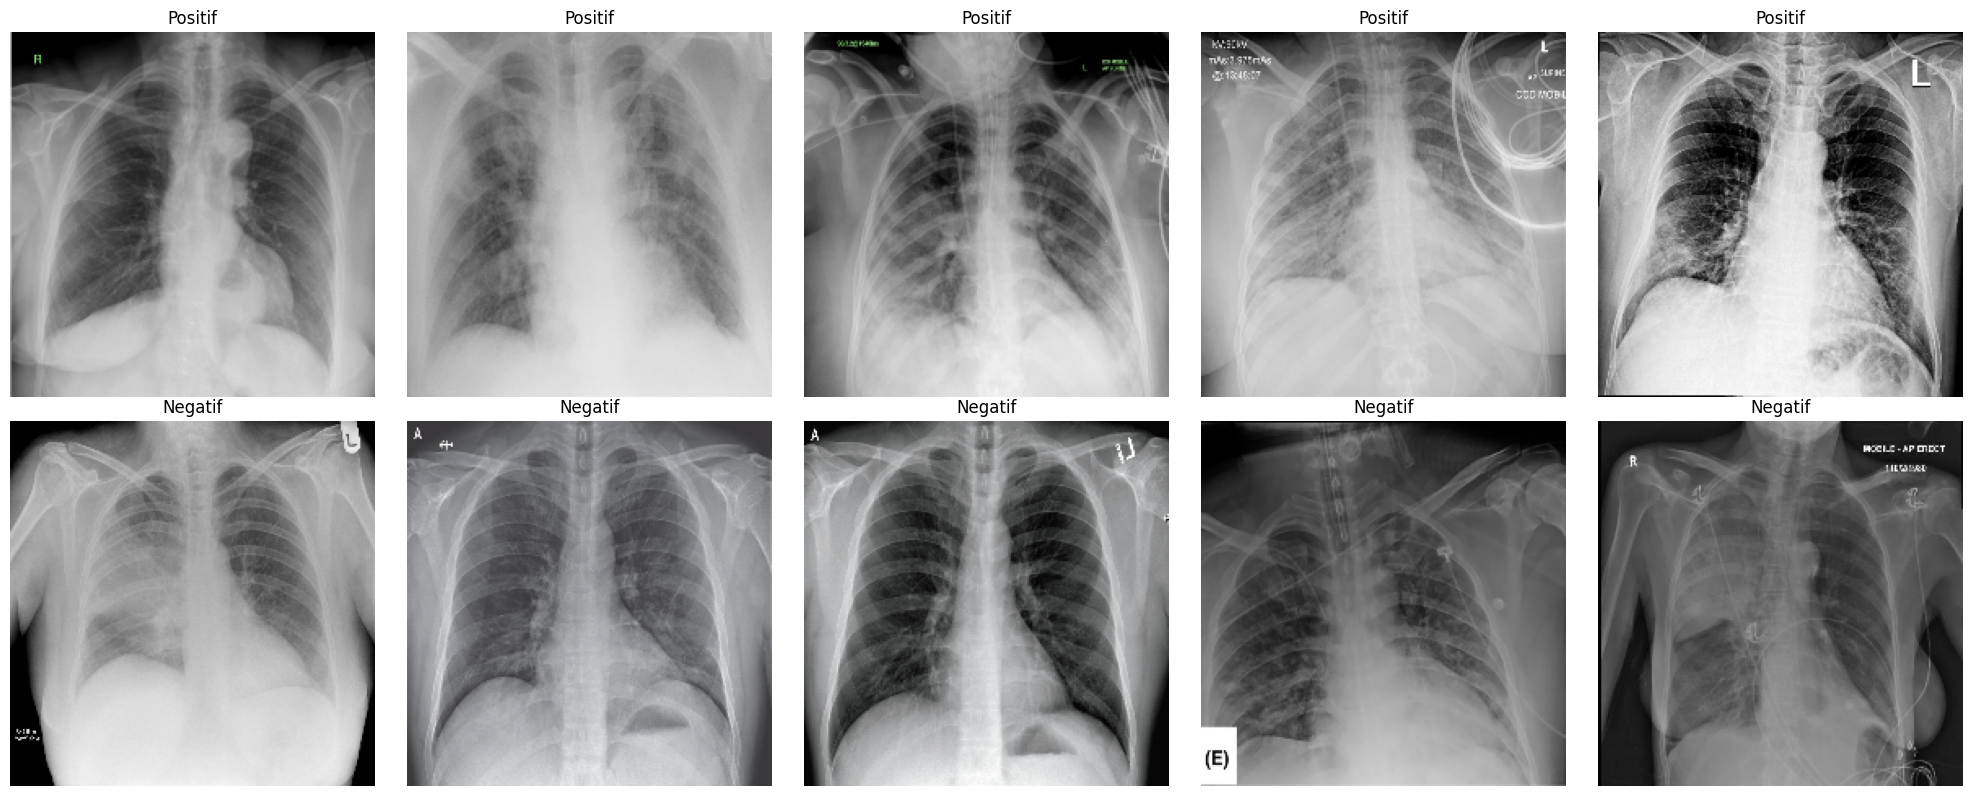

In [ ]:
num_images_per_category = 5

fig, axes = plt.subplots(2, num_images_per_category, figsize=(20, 8))

for category_index, category in enumerate(categories):
  category_path = os.path.join(data_path, category)
  image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

  for i in range(num_images_per_category):
      if i < len(image_files): # Check to avoid index out of range errors
          image_path = os.path.join(category_path, image_files[i])
          try:
              img = cv2.imread(image_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, image_size)
              axes[category_index, i].imshow(img)
              axes[category_index, i].axis('off')
              axes[category_index, i].set_title(category)
          except Exception as e:
              print(f"Error loading image {image_path}: {e}")
              axes[category_index, i].axis('off')
      else:
          axes[category_index, i].axis('off') # Hide empty subplots

plt.tight_layout()
plt.show()


Setelah melihat beberapa gambar, kita dapat melihat bahwa


*   Gambar kurang kontras
*   Gambar kurang tajam (pada bagian tepi gambar)
*   Gambar kurang terang di beberapa bagian




### Image Pre-Processing

Pada bagian ini, saya melakukan beberapa pre-processing untuk meningkatkan image secara kualitas

In [ ]:
def enhance_image(img, size=(224, 224)):
    img = cv2.resize(img, size)

    # === Step 1: Konversi ke grayscale agar fokus ke struktur paru
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # === Step 2: CLAHE untuk kontras lokal
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)

    # === Step 3: Sharpening (lebih tajam)
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(clahe_img, -1, sharpen_kernel)

    # === Step 4: Gamma Correction (terangin sedikit bagian gelap)
    gamma = 1.3
    table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(sharpened, table)

    # === Step 5: Ubah kembali ke 3 channel RGB untuk CNN input
    img_final = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)

    return img_final

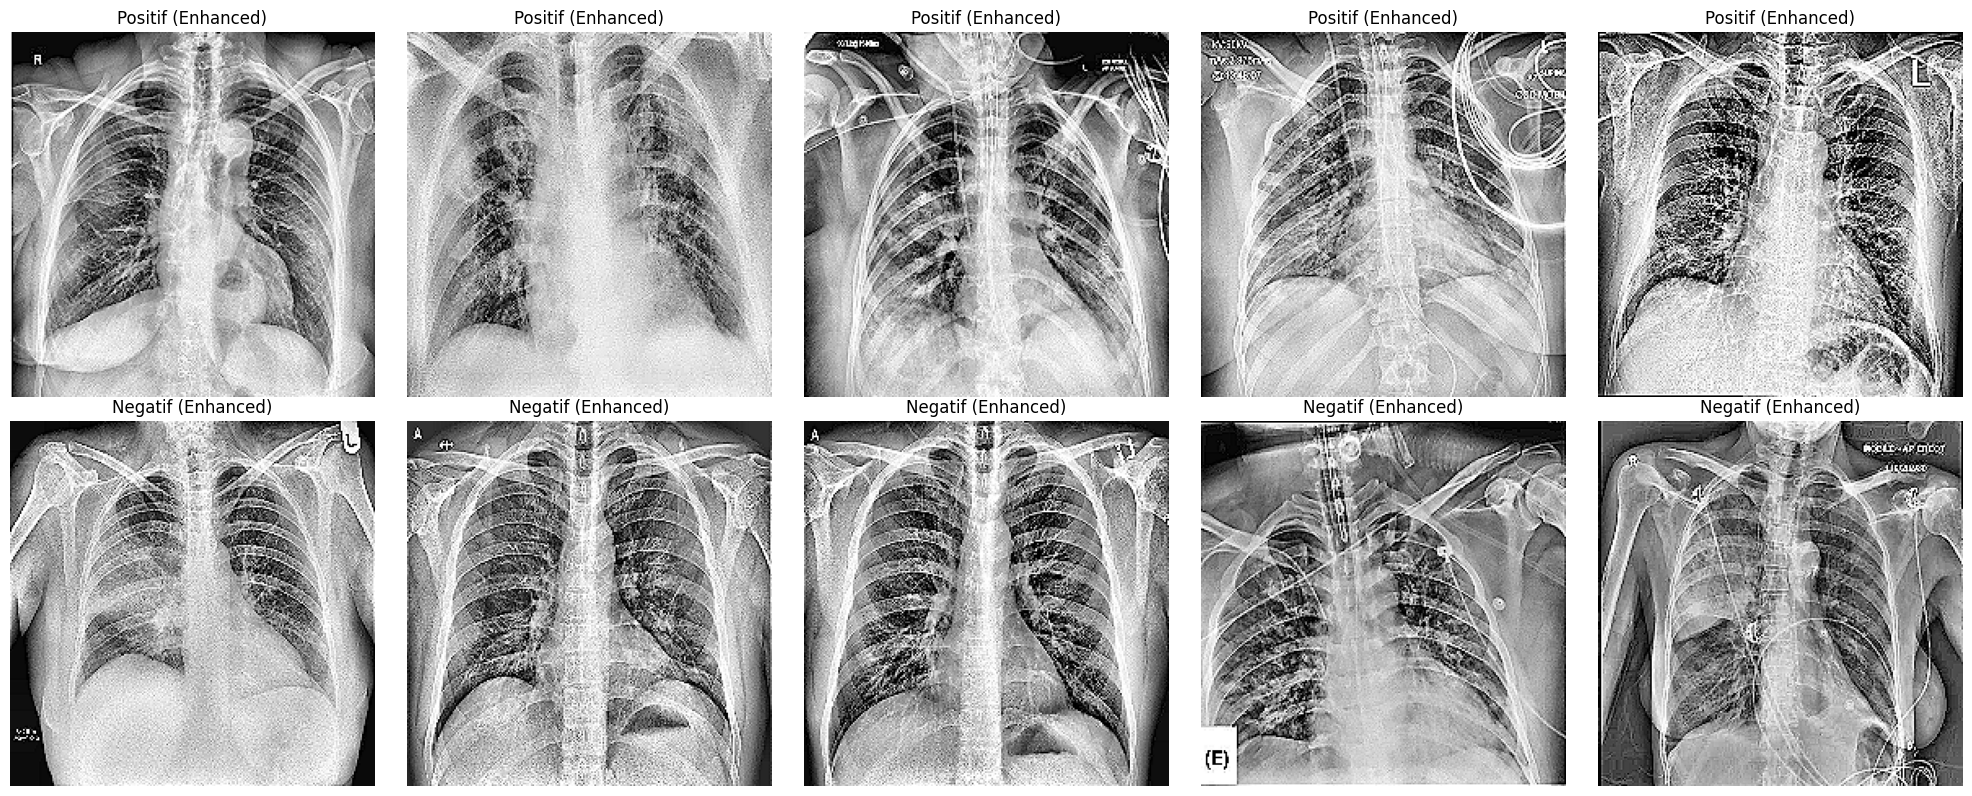

In [ ]:
# Lihat gambar setelah dilakukan pre-processing

num_images_per_category = 5

fig, axes = plt.subplots(2, num_images_per_category, figsize=(20, 8))

for category_index, category in enumerate(categories):
  category_path = os.path.join(data_path, category)
  image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

  for i in range(num_images_per_category):
      if i < len(image_files):
          image_path = os.path.join(category_path, image_files[i])
          try:
              img = cv2.imread(image_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img_enhanced = enhance_image(img.copy()) # Apply image enhancement

              axes[category_index, i].imshow(img_enhanced) # Display the enhanced image
              axes[category_index, i].axis('off')
              axes[category_index, i].set_title(f"{category} (Enhanced)")
          except Exception as e:
              print(f"Error loading/enhancing image {image_path}: {e}")
              axes[category_index, i].axis('off')
      else:
          axes[category_index, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# === Load Data ===
def load_data():
    images, labels = [], []
    for label in categories:
        folder_path = os.path.join(data_path, label)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = enhance_image(img, size=image_size)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_data()
X = X / 255.0

In [ ]:
# === Encode Label ===
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:
# === Augmentasi untuk data Positif ===
augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_pos = X[y == 'Positif']
y_pos = y_categorical[y == 'Positif']
X_neg = X[y == 'Negatif']
y_neg = y_categorical[y == 'Negatif']

repeat_factor = int(np.ceil(len(X_neg) / len(X_pos)))
X_pos_augmented, y_pos_augmented = [], []

for _ in range(repeat_factor):
    for x_batch, y_batch in augmentor.flow(X_pos, y_pos, batch_size=len(X_pos), shuffle=False):
        X_pos_augmented.append(x_batch)
        y_pos_augmented.append(y_batch)
        break

X_pos_aug = np.vstack(X_pos_augmented)[:len(X_neg)]
y_pos_aug = np.vstack(y_pos_augmented)[:len(X_neg)]

X_balanced = np.concatenate([X_neg, X_pos_aug])
y_balanced = np.concatenate([y_neg, y_pos_aug])

In [ ]:
# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42,
    stratify=np.argmax(y_balanced, axis=1)
)

In [ ]:
# === Augmentasi Training ===
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Modelling

Pada bagian ini, saya akan membangun model CNN dengan penjelasan lebih detail terdapat pada laporan. Pada bagian ini juga saya memberikan class weight untuk memberikan bobot lebih pada kelas positif (kelas minoritas) agar model tidak bias.

In [ ]:
# === CNN Model ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Class Weight ===
y_balanced_labels = np.argmax(y_balanced, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_balanced_labels),
    y=y_balanced_labels
)
class_weights = dict(enumerate(class_weights))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# === Callbacks ===
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('cnn_covid_balanced.h5', save_best_only=True)
]

# Model melakukan early stopping untuk mencegah overfitting

In [ ]:
# === Training ===
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    class_weight=class_weights)

# === Evaluation ===
model = tf.keras.models.load_model('cnn_covid_balanced.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\n🎯 Test Accuracy (CNN): {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3887 - loss: 3.6482

5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.3880 - loss: 3.6288 - val_accuracy: 0.5000 - val_loss: 0.8729
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4625 - loss: 0.8346

5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.4645 - loss: 0.8246 - val_accuracy: 0.5000 - val_loss: 0.6735
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5180 - loss: 0.6700

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5161 - loss: 0.6716 - val_accuracy: 0.5500 - val_loss: 0.6547
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5197 - loss: 0.7099

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.5207 - loss: 0.7086 - val_accuracy: 0.8750 - val_loss: 0.6118
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5496 - loss: 0.6770

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5499 - loss: 0.6765 - val_accuracy: 0.5000 - val_loss: 0.5888
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5978 - loss: 0.6441

5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5997 - loss: 0.6419 - val_accuracy: 0.6750 - val_loss: 0.4858
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6731 - loss: 0.6189

5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6763 - loss: 0.6163 - val_accuracy: 0.8750 - val_loss: 0.3764
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5833 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.9431
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6117 - loss: 0.5587 - val_accuracy: 0.7000 - val_loss: 0.5679
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8137 - loss: 0.4046 - val_accuracy: 0.6750 - val_loss: 0.6910
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8625 - loss: 0.3471 - val_accuracy: 0.6500 - val_loss: 1.1318
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8639 - loss: 0.2949 - val_accuracy: 0.6500 - val_loss: 1.3616
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8483 - loss: 0.2982 - val_accuracy: 0.5750 - val_loss: 2.8402
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8836 - loss: 0.3301 - val_accuracy: 0.6000 - val_loss: 2.4391
Epoch 15/30
5/

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.8750 - loss: 0.3797

🎯 Test Accuracy (CNN): 0.8750


### Evaluasi Model

Pada bagian ini, kita dapat melihat evaluasi kinerja model berdasarkan confusion matrix serta grafik akurasi dan loss.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


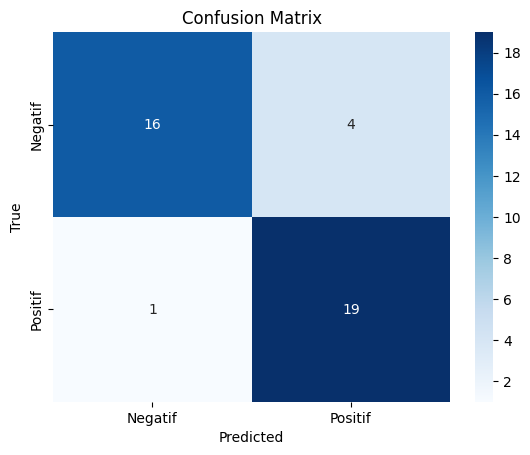


Classification Report:
               precision    recall  f1-score   support

     Negatif       0.94      0.80      0.86        20
     Positif       0.83      0.95      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



In [ ]:
# === Confusion Matrix & Report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

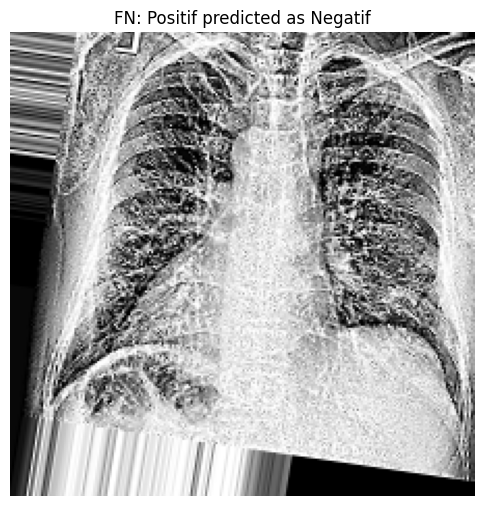

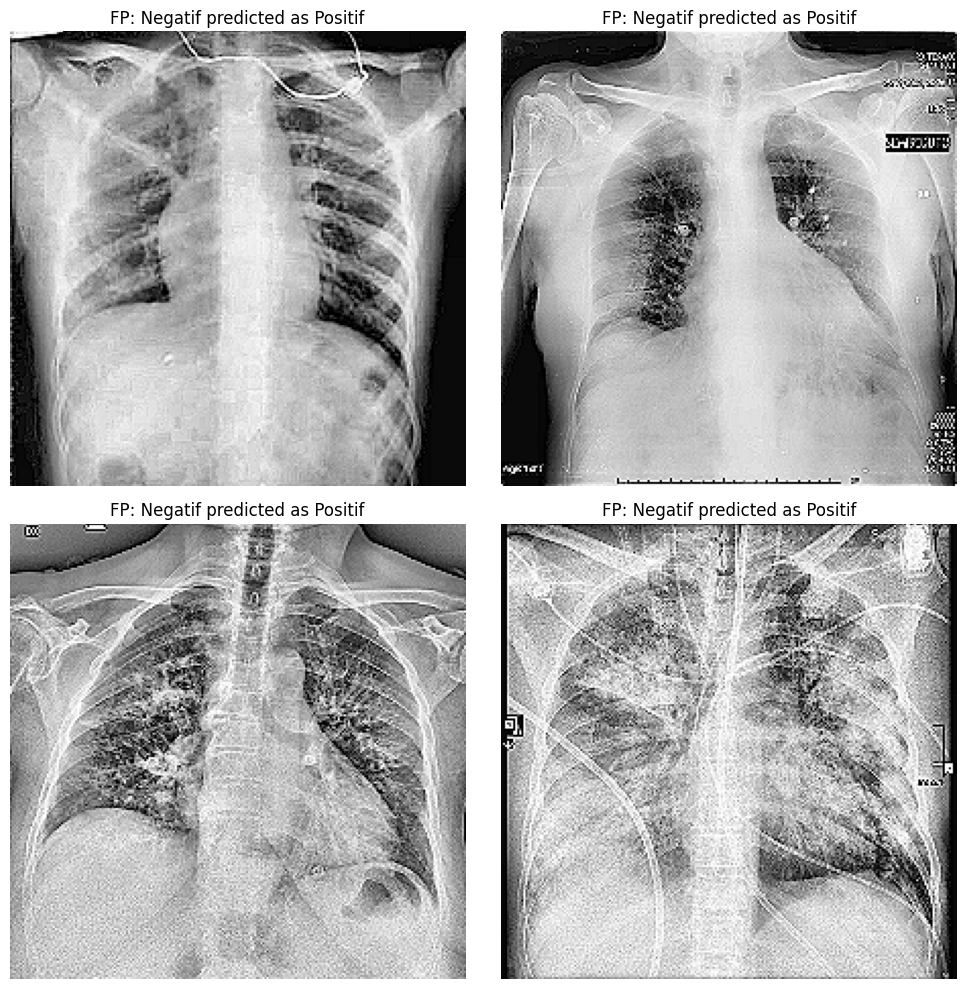

In [ ]:
# menampilkan gambar yang tergolong ke dalam false positive dan false negative

# Find indices of false negatives and false positives
false_negatives = np.where((y_true == 1) & (y_pred_classes == 0))[0]
false_positives = np.where((y_true == 0) & (y_pred_classes == 1))[0]

# Function to display images in a grid
def display_images(images, titles, num_cols=2):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

    # Check if axes is 1-dimensional and convert to 2-dimensional if necessary
    if num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)  # Reshape to 2D

    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(images[i])
        axes[row, col].set_title(titles[i])
        axes[row, col].axis('off')

    # Hide any unused subplots
    for j in range(num_images, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()


# Display false negatives
num_to_display = 5
fn_indices_to_display = false_negatives[:min(num_to_display, len(false_negatives))]
fn_images = X_test[fn_indices_to_display]
fn_titles = [f"FN: {encoder.classes_[y_true[i]]} predicted as {encoder.classes_[y_pred_classes[i]]}" for i in fn_indices_to_display]
display_images(fn_images, fn_titles)


# Display false positives
fp_indices_to_display = false_positives[:min(num_to_display, len(false_positives))]
fp_images = X_test[fp_indices_to_display]
fp_titles = [f"FP: {encoder.classes_[y_true[i]]} predicted as {encoder.classes_[y_pred_classes[i]]}" for i in fp_indices_to_display]
display_images(fp_images, fp_titles)


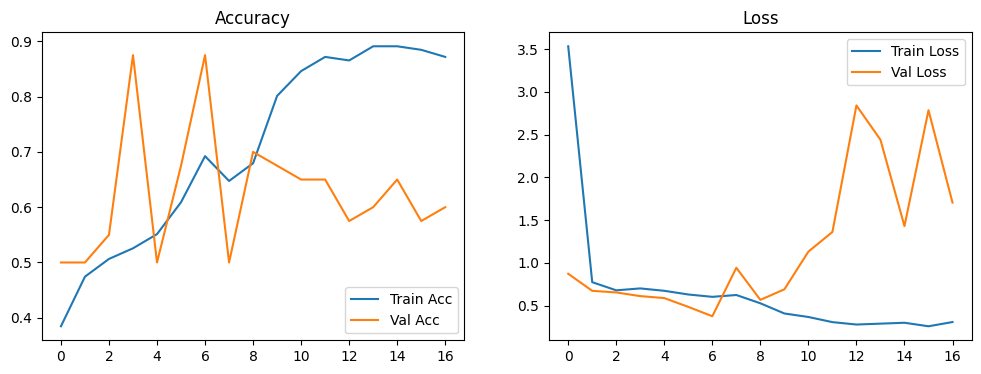

In [ ]:
# === Plot Akurasi dan Loss ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
